# Image-to-Image Translation with Conditional Adversarial Networks
#### Isola et al.
In this paper different computational vision problems such as semantic segmentation, colorization, ... are reformulated into a general framework of GAN. General in the case of the loss function which will be automatically driven by the GAN and used to be sensitive to various things such as structure, ...
Here we will see the proposed network for the task of image translation in CMP dataset which is building facade to their labels and vice verca.

In [1]:
# Imports
%reload_ext autoreload
%autoreload 1

import os, sys
sys.path.append('../')

from tools_general import tf, np
from IPython.display import HTML, display, Image
from tools_train import get_train_params, OneHot, vis_square
from tools_data import retransform
from tools_config import data_dir, best_models

data_dir = '.' + data_dir
best_models = '.' + best_models

In [2]:
# define parameters
networktype = 'img2imgGAN_CMP'

## Network definitions

In [3]:
from tools_networks import clipped_crossentropy, dropout, conv, deconv

def conch(A, B):
    '''Concatenate channelwise'''
    with tf.variable_scope("deconv"):
        X = tf.concat([A, B], axis=3)
        return X
      
def create_gan_G(GE0, is_training, Cout=3, trainable=True, reuse=False, networktype='ganG'):

    with tf.variable_scope(networktype, reuse=reuse):
        GE1 = conv(GE0, is_training, kernel_w=4, stride=2, Cout=64 , pad=1, trainable=trainable, act='lreLu', norm=None, name='ENconv1')  # 128
        GE2 = conv(GE1, is_training, kernel_w=4, stride=2, Cout=128, pad=1, trainable=trainable, act='lreLu', norm='instance', name='ENconv2')  # 64
        GE3 = conv(GE2, is_training, kernel_w=4, stride=2, Cout=256, pad=1, trainable=trainable, act='lreLu', norm='instance', name='ENconv3')  # 32
        GE4 = conv(GE3, is_training, kernel_w=4, stride=2, Cout=512, pad=1, trainable=trainable, act='lreLu', norm='instance', name='ENconv4')  # 16
        GE5 = conv(GE4, is_training, kernel_w=4, stride=2, Cout=512, pad=1, trainable=trainable, act='lreLu', norm='instance', name='ENconv5')  # 8
        GE6 = conv(GE5, is_training, kernel_w=4, stride=2, Cout=512, pad=1, trainable=trainable, act='lreLu', norm='instance', name='ENconv6')  # 4
        GE7 = conv(GE6, is_training, kernel_w=4, stride=2, Cout=512, pad=1, trainable=trainable, act='lreLu', norm='instance', name='ENconv7')  # 2
        
        GBNeck = conv(GE7, is_training, kernel_w=4, stride=2, Cout=512, pad=1, trainable=trainable, act='lreLu', norm='instance', name='GBNeck')  # 1 - Bottleneck
        
        GD7 = deconv(GBNeck, is_training, kernel_w=4, stride=2, Cout=512, epf=2, trainable=trainable, act='reLu', norm='instance', name='DEdeconv1');GD7 = dropout(GD7, is_training, p=0.5);  # 2
        GD6 = deconv(conch(GD7, GE7), is_training, kernel_w=4, stride=2, Cout=512, epf=2, trainable=trainable, act='reLu', norm='instance', name='DEdeconv2');GD6 = dropout(GD6, is_training, p=0.5)  # 4
        GD5 = deconv(conch(GD6, GE6), is_training, kernel_w=4, stride=2, Cout=512, epf=2, trainable=trainable, act='reLu', norm='instance', name='DEdeconv3');GD5 = dropout(GD5, is_training, p=0.5)  # 8
        GD4 = deconv(conch(GD5, GE5), is_training, kernel_w=4, stride=2, Cout=512, epf=2, trainable=trainable, act='reLu', norm='instance', name='DEdeconv4')  # 16
        GD3 = deconv(conch(GD4, GE4), is_training, kernel_w=4, stride=2, Cout=512, epf=2, trainable=trainable, act='reLu', norm='instance', name='DEdeconv5')  # 32
        GD2 = deconv(conch(GD3, GE3), is_training, kernel_w=4, stride=2, Cout=256, epf=2, trainable=trainable, act='reLu', norm='instance', name='DEdeconv6')  # 64
        GD1 = deconv(conch(GD2, GE2), is_training, kernel_w=4, stride=2, Cout=128, epf=2, trainable=trainable, act='reLu', norm='instance', name='DEdeconv7')  # 128
        GD0 = deconv(conch(GD1, GE1), is_training, kernel_w=4, stride=2, Cout=Cout, epf=2, trainable=trainable, act=None, norm='instance', name='DEdeconv8')  # 256
        
        Xout = tf.nn.tanh(GD0)
        
    return Xout

def create_gan_D(inSource, inTarget, is_training, trainable=True, reuse=False, networktype='ganD'):
    with tf.variable_scope(networktype, reuse=reuse):
        inSource = conch(inSource, inTarget)
        Dxz = conv(inSource, is_training, kernel_w=4, stride=2, Cout=64,  trainable=trainable, act='lrelu', norm=None, name='conv1')  # 128
        Dxz = conv(Dxz, is_training, kernel_w=4, stride=2, Cout=128, trainable=trainable, act='lrelu', norm='instance', name='conv2')  # 64
        Dxz = conv(Dxz, is_training, kernel_w=4, stride=2, Cout=256, trainable=trainable, act='lrelu', norm='instance', name='conv3')  # 32
        Dxz = conv(Dxz, is_training, kernel_w=1, stride=1, Cout=1,   trainable=trainable, act='lrelu', norm='instance', name='conv4')  # 32
        Dxz = tf.nn.sigmoid(Dxz)
    return Dxz

def create_pix2pix_trainer(base_lr=1e-4, networktype='pix2pix'):
    Cout = 3
    lambda_weight = 100
    
    is_training = tf.placeholder(tf.bool, [], 'is_training')

    inSource = tf.placeholder(tf.float32, [None, 256, 256, Cout])
    inTarget = tf.placeholder(tf.float32, [None, 256, 256, Cout])

    GX = create_gan_G(inSource, is_training, Cout=Cout, trainable=True, reuse=False, networktype=networktype + '_G') 

    DGX = create_gan_D(GX, inTarget, is_training, trainable=True, reuse=False, networktype=networktype + '_D')
    DX = create_gan_D(inSource, inTarget, is_training, trainable=True, reuse=True, networktype=networktype + '_D')
    
    ganG_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=networktype + '_G')
    #print(len(ganG_var_list), [var.name for var in ganG_var_list])

    ganD_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=networktype + '_D')
    #print(len(ganD_var_list), [var.name for var in ganD_var_list])
              
    Gscore_L1 = tf.reduce_mean(tf.abs(inTarget - GX))
    Gscore = clipped_crossentropy(DGX, tf.ones_like(DGX)) + lambda_weight * Gscore_L1
    
    Dscore = clipped_crossentropy(DGX, tf.zeros_like(DGX)) + clipped_crossentropy(DX, tf.ones_like(DX))
    
    Gtrain = tf.train.AdamOptimizer(learning_rate=base_lr, beta1=0.5).minimize(Gscore, var_list=ganG_var_list)
    Dtrain = tf.train.AdamOptimizer(learning_rate=base_lr, beta1=0.5).minimize(Dscore, var_list=ganD_var_list)
    
    return Gtrain, Dtrain, Gscore, Dscore, is_training, inSource, inTarget, GX

The dropouts inside the generator are supposed to be the source of variability. But we will see how effective this can actually work ...

## Training
The following cell type can be turned into code and used for training image2imageGAN. But i used the console code and saved results in best model directory. 

direction = 'A2B'
networktype = 'img2imgGAN_CMP_%s'%direction
    
batch_size = 1
base_lr = 0.0002  # 1e-4
epochs = 200

work_dir = expr_dir + '%s/%s/' % (networktype, datetime.strftime(datetime.today(), '%Y%m%d'))
if not os.path.exists(work_dir): os.makedirs(work_dir)

data, max_iter, test_iter, test_int, disp_int = get_train_params(data_dir, batch_size, epochs=epochs, test_in_each_epoch=1, networktype=networktype)

tf.reset_default_graph() 
sess = tf.InteractiveSession()

Gtrain, Dtrain, Gscore, Dscore, is_training, inSource, inTarget, GX = create_pix2pix_trainer(base_lr, networktype=networktype)
tf.global_variables_initializer().run()

var_list = [var for var in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES) if (networktype.lower() in var.name.lower()) and ('adam' not in var.name.lower())]  
saver = tf.train.Saver(var_list=var_list, max_to_keep=100)

Xeval = np.load(data_dir + '%s/eval.npz' % networktype.replace('_A2B','').replace('_B2A',''))['data']    
if direction == 'A2B':# from label to natural image
        A_test = Xeval[:4, :, :, 3:]
        B_test = Xeval[:4, :, :, :3]
else:# from natural image to labels
        A_test = Xeval[:4, :, :, :3]
        B_test = Xeval[:4, :, :, 3:]  

vis_square(retransform(A_test), [2,2], save_path=work_dir + 'Aorig.jpg')
vis_square(retransform(B_test), [2,2], save_path=work_dir + 'Borig.jpg')

k = 1

for it in range(1, max_iter): 
    X = data.train.next_batch(batch_size)
    if direction == 'A2B':# from label to natural image
        A = X[:, :, :, 3:]
        B = X[:, :, :, :3]
    else:# from natural image to labels
        A = X[:, :, :, :3]
        B = X[:, :, :, 3:]            

    for itD in range(k):
        cur_Dscore, _ = sess.run([Dscore, Dtrain], feed_dict={inSource: A, inTarget: B, is_training:True})

    cur_Gscore, _ = sess.run([Gscore, Gtrain], feed_dict={inSource: A, inTarget: B, is_training:True})

    if it % disp_int == 0:
        GX_sample = sess.run(GX, feed_dict={inSource:A_test, is_training:True})

        vis_square(retransform(GX_sample), [2,2], save_path=work_dir + 'Iter_%d.jpg' % it)
        saver.save(sess, work_dir + "%.3d_model.ckpt" % it)
        if ('cur_Dscore' in vars()) and ('cur_Gscore' in vars()):
            print("Iteration #%4d, Train Gscore = %f, Dscore=%f" % (it, cur_Gscore, cur_Dscore))

## 1) CMP Labels to Images (B2A)
From the labels the building faces are produced

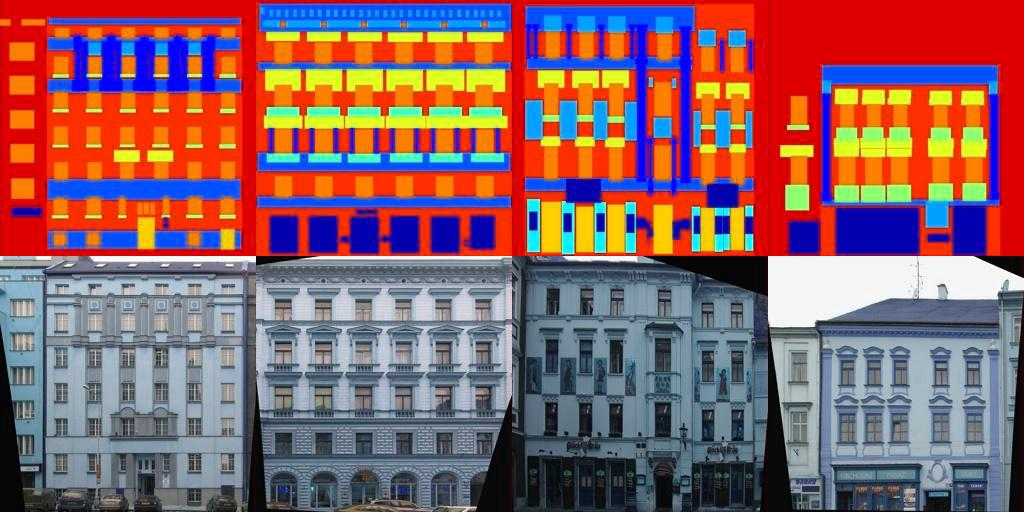

In [4]:
direction = 'B2A'
networktype = 'img2imgGAN_CMP_%s'%direction

work_dir = best_models + '%s/'%networktype

Xtest = np.load(data_dir + '%s/test.npz' % networktype.replace('_A2B','').replace('_B2A',''))['data']    

task = work_dir+"task.jpg"
Image(task)

In [7]:
best_iter = 112000#visually selected
best_model = work_dir + "%.3d_model.ckpt" % best_iter

lambda_weight = 100

tf.reset_default_graph() 
demo_sess = tf.InteractiveSession()

is_training = tf.placeholder(tf.bool, [], 'is_training')

inSource = tf.placeholder(tf.float32, [None, 256, 256, 3])
inTarget = tf.placeholder(tf.float32, [None, 256, 256, 3])

GX = create_gan_G(inSource, is_training, Cout=3, trainable=True, reuse=False, networktype=networktype + '_G') 

ganG_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=networktype + '_G')

tf.global_variables_initializer().run()

saver = tf.train.Saver(var_list=ganG_var_list)
saver.restore(demo_sess, best_model) 

INFO:tensorflow:Restoring parameters from ../trained_models/img2imgGAN_CMP_B2A/112000_model.ckpt


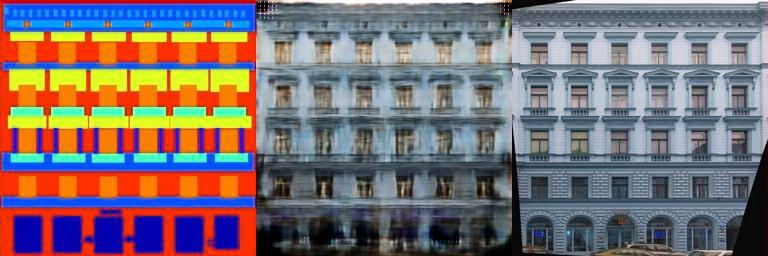

In [10]:
img_index = 1
A_test = Xtest[img_index:img_index+1, :, :, 3:]
B_test = Xtest[img_index:img_index+1, :, :, :3]
     
GX_sample = demo_sess.run(GX, feed_dict={inSource:A_test, is_training:True})
visImg = retransform(np.concatenate([A_test, GX_sample, B_test]))
visImg_path = vis_square(visImg, [1,3], save_path=work_dir + 'generated_%s.jpg' % img_index)

Image(filename=visImg_path)

Try running the previous cell multiple times. There is no variablility (as least to normal eyes) with the above generated image from the label.

## 1) CMP Images to Labels (A2B)
From the building faces the labels are produced

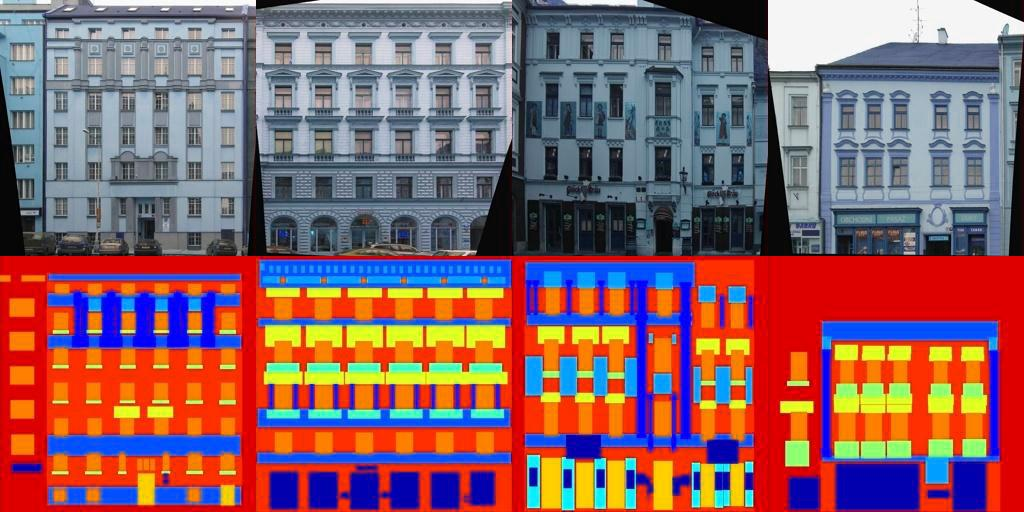

In [11]:
direction = 'A2B'
networktype = 'img2imgGAN_CMP_%s'%direction

work_dir = best_models + '%s/'%networktype

Xtest = np.load(data_dir + '%s/test.npz' % networktype.replace('_A2B','').replace('_B2A',''))['data']    

task = work_dir+"task.jpg"
Image(task)

In [12]:
best_iter = 137200#visually selected
best_model = work_dir + "%.3d_model.ckpt" % best_iter

lambda_weight = 100

tf.reset_default_graph() 
demo_sess = tf.InteractiveSession()

is_training = tf.placeholder(tf.bool, [], 'is_training')

inSource = tf.placeholder(tf.float32, [None, 256, 256, 3])
inTarget = tf.placeholder(tf.float32, [None, 256, 256, 3])

GX = create_gan_G(inSource, is_training, Cout=3, trainable=True, reuse=False, networktype=networktype + '_G') 

ganG_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=networktype + '_G')

tf.global_variables_initializer().run()

saver = tf.train.Saver(var_list=ganG_var_list)
saver.restore(demo_sess, best_model) 

INFO:tensorflow:Restoring parameters from ../trained_models/img2imgGAN_CMP_A2B/137200_model.ckpt


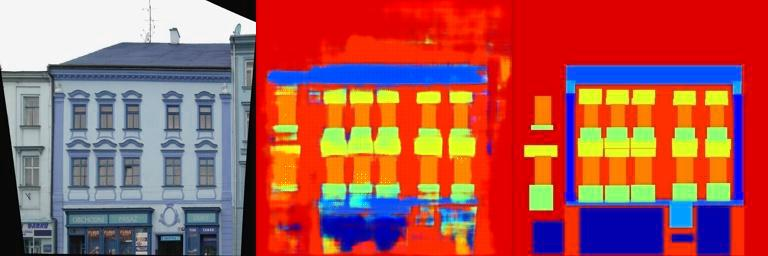

In [18]:
img_index = 3
A_test = Xtest[img_index:img_index+1, :, :, :3]
B_test = Xtest[img_index:img_index+1, :, :, 3:]
     
GX_sample = demo_sess.run(GX, feed_dict={inSource:A_test, is_training:True})
visImg = retransform(np.concatenate([A_test, GX_sample, B_test]))
visImg_path = vis_square(visImg, [1,3], save_path=work_dir + 'generated_%s.jpg' % img_index)

Image(filename=visImg_path)